# Around the World photo classifier

This photo app classifier, has four purposes:
1. It extracts image datetimes (if available)
2. It extracts and visualizes image GPS data (if available)
3. It provides object classification via yolo3v, ImageNet and personalized CNNs
4. It filters, sorts and rearranges images based on the extraced data

Datetimes and GPS data are extracted from the image meta data using the pillow library.

The photo classification is realized in three different approaches:
1. by using a yolov3 object detection algorithm. Here, I am using yolov3 pretrained wheights. Deep Learning Inference with own images enables a detection of up to 80 different classes within one image. A Boundary box with a class description is provided and stored in a separate folder **.../path_to_your_image_folder_name_** _yolo_class_  as well as stored in an html table (**your_image_folder_name.html**).
2. by using a CNN based pretrained model from Torchvision via Transfer Learning. As a standard VGG16 is chosen. However, you can replace VGG16 by any ozjer torchvision model. VGG16 is using the whole ImageNet classification system, The total number of classes is 1000. The file **data/imagenet_classes.txt** provides a dictionary of all one 1000 classes.
3. by using an own CNN based architecture with a layer combination of three times 'Conv-ReLU-MaxPool', deeply enough for sufficient feature extraction and an appropriate image size/feature reduction. The goal of this CNN is to filter peronalized images, e.g. to identify images of yourself. However, for this classification step you have to provide a dataset of at least 300 personolized images. This CNN is not pretrained. You have to train it separately. For further information, follow the instruction in the Jupyter Notebook.


## Content
### <a href='#part_a'>Part A - Prepare Images and Create DataFrame</a>
#### <a href='#part_a_1'>Part A 1 - Libraries</a>
#### <a href='#part_a_2'>Part A 2 - Path setting</a>
#### <a href='#part_a_3'>Part A 3 - DateTime setting</a>
#### <a href='#part_a_4'>Part A 4 - Yolov3</a>
#### <a href='#part_a_5'>Part A 5 - ImageNet</a>
#### <a href='#part_a_6'>Part A 6 - Meta data</a>
#### <a href='#part_a_7'>Part A 7 - HTML thumbnail view</a>
#### <a href='#part_a_8'>Part A 8 - Put all together</a>
#### <a href='#part_a_9'>Part A 9 - Convert DataFrame to HTML</a>
#### <a href='#part_a_10'>Part A 10 - Create GMAPS</a>

### <a href='#part_b'>Part B - Analyze DataFrame</a>
#### <a href='#part_b_1'>Part B 1 - Time Periods</a>
#### <a href='#part_b_2'>Part B 2 - GPS Areas</a>
#### <a href='#part_b_3'>Part B 3 - Filter by Groups</a>
#### <a href='#part_b_4'>Part B 4 - Personal Filter</a>
### <a href='#Appendix'>Appendix - Yolo and ImageNet classes</a>

<a id='part_a'></a>

## Part A - Prepare Images and Create DataFrame

In [1]:
!pip install torchvision
!pip install torch

<a id='part_a_1'></a>

## Part A 1 - Libraries

In [2]:
import os
try:
    import win32com.client
    speaker = win32com.client.Dispatch("SAPI.SpVoice")
    speaker.Speak("Let's begin")
except:
    os.system("say 'Let\'s begin")  
else: 
    print('No speak output')
   

In [3]:
# standard libraries
import os, sys, time, datetime, random
from glob import glob
from shutil import copyfile
from datetime import datetime, date, timedelta
import ast
import itertools
import json

# standard data science libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle   
from matplotlib.pyplot import imshow
%matplotlib inline 

# for yolo
from data.models import *
from utils import *

# for ImageNet classification using VGG16
import torch
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torch.autograd import Variable

# for images 
import PIL
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

# for GMPAS
import gmaps
import gmaps.datasets
gmaps.configure(api_key='')

# ipywidgets
import ipywidgets as widgets
from ipywidgets import ToggleButton, RadioButtons, Image, VBox, HTML, Text, HBox, VBox, Layout, Dropdown
style = {'description_width': 'initial'}
from ipyfilechooser import FileChooser
from functools import wraps

# for HTML displaying and output
from io import BytesIO
from IPython.display import Markdown, display, HTML
import base64
import io

def printmd(string):
    display(Markdown(string))
    
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )


cwd = os.getcwd()
print(cwd)

/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/atw_classifier/templates


In [4]:
def set_radiobutton(value, description, argv):
    w = widgets.RadioButtons(
        options=[op for op in argv],
        value=value, # Defaults to 'pineapple'
        #layout={'width': 'max-content'}, # If the items' names are long
        description=description,
        disabled=False
    )
    return w

In [5]:
import os



class DirListView():
    def __init__(self,path):
        self.path= path

    template_name = 'main/list_dir.html'

    def get_queryset(self):
        files = []
        for filename in os.listdir(self.path):
            
            files.append(filename)
        return files

cwd = os.getcwd()
print(cwd)
folder_view = DirListView(cwd)
print(folder_view)

/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/atw_classifier/templates


<a id='part_a_2'></a>

## Part A 2 - Path setting
- Copy this **around_the_world_classifier.ipynb** notebook  as well as the **data** in the same folder with your image main folder. 
- Provide the name of your image folder in the next cell

### Path to image_folder
folder of original images

In [6]:
# file_path to image_folder
image_folder_fc = FileChooser()
display(image_folder_fc)

FileChooser(path='/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/atw_classifier/templates', f…

### Path to yolo_folder
folder for storing Yolo results

In [7]:
# file_path to yolo_class_folder
yolo_folder_fc = FileChooser()
display(yolo_folder_fc)

FileChooser(path='/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/atw_classifier/templates', f…

### Path to person_folder
folder for storing 

In [8]:
# file_path to person folder
person_folder_fc = FileChooser()
display(person_folder_fc)

FileChooser(path='/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/atw_classifier/templates', f…

### Path to security copy of DataFrame

In [9]:
# file_path to security copy of DataFrame 
file_path_copy_dataframe_fc = FileChooser()
display(file_path_copy_dataframe_fc)

FileChooser(path='/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/atw_classifier/templates', f…

In [10]:
rad_save_path = set_radiobutton('no', 'Save Path', ['no', 'yes'])
display(rad_save_path)

RadioButtons(description='Save Path', options=('no', 'yes'), value='no')

In [11]:
if rad_save_path.value == 'yes':
    file_path_str = image_folder_fc.selected_path + ',' + yolo_folder_fc.selected_path + ',' + person_folder_fc.selected_path + ',' + file_path_copy_dataframe_fc.selected_path
    with open('file_path.txt', 'w') as f:
        f.write(file_path_str)

In [12]:
image_folder = image_folder_fc.selected_path
yolo_folder = yolo_folder_fc.selected_path
person_folder = person_folder_fc.selected_path
file_path_copy_dataframe = file_path_copy_dataframe_fc.selected_path

try:
    with open('file_path.txt', 'r') as f:
        file_path_str =f.read()
except:
    pass
        
if image_folder == None:
    try:
        image_folder = file_path_str.split(',')[0]
        print('image_folder found ...')
    except:
        print('No image_folder found')
else: 
    print('image_folder found ...')
    
        
if yolo_folder == None:
    try:
        yolo_folder = file_path_str.split(',')[1]
        print('yolo_folder found ...')
    except:
        print('No yolo_folder found') 
else: 
    print('yolo_folder found ...')
    
        
if person_folder == None:
    try:
        person_folder = file_path_str.split(',')[2]
        print('person_folder found ...')
    except:
        print('No person_folder found') 
else: 
    print('person_folder found ...')
    

if file_path_copy_dataframe == None:
    try:
        file_path_copy_dataframe = file_path_str.split(',')[3]
        print('file_path_copy_dataframe found ...')
    except:
        print('No file_path_copy_dataframe found')
else: 
    print('file_path_copy_dataframe found ...')


image_folder found ...
yolo_folder found ...
person_folder found ...
file_path_copy_dataframe found ...


In [13]:
try:
    os.mkdir(yolo_folder)
except: 
    pass
try:
    os.mkdir(person_folder)
except: 
    pass

path_cwd = os.path.abspath(os.getcwd())
print('CWD: ', path_cwd)
print('image_folder: ', image_folder)
print('yolo_folder: ', yolo_folder)
print('person_folder: ', person_folder)
print('file_path_copy_dataframe', file_path_copy_dataframe)

CWD:  /Users/davidhartmann/Dropbox/Python/around_the_world_classifier/atw_classifier/templates
image_folder:  /Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images
yolo_folder:  /Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_yolo
person_folder:  /Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_personal
file_path_copy_dataframe /Users/davidhartmann/Dropbox/Python/around_the_world_classifier/temp


<a id='part_a_3'></a>

## Part A 3 - DateTime Setting

In [14]:
start_end_dict = json.load(open("start_end_dict.txt"))

start_datetime = datetime.strptime(start_end_dict['start_date'] + ' 00:00:00', '%Y-%m-%d %H:%M:%S')
end_datetime = datetime.strptime(start_end_dict['end_date'] + ' 00:00:00', '%Y-%m-%d %H:%M:%S')

def set_df_datetime_ranges(start_value, end_value):
    #start_value = datetime.strptime('2000-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
    #end_value = datetime.now()

    start_value_date = start_value.date()
    end_value_date = end_value.date()

    start_date = widgets.DatePicker(value=start_value.date())
    end_date = widgets.DatePicker(value=end_value.date())

    start_hour = widgets.Dropdown(options=[i for i in range(0,24)], value=start_value.hour, description='H:')
    start_min = widgets.Dropdown(options=[i for i in range(0,60)], value=start_value.minute, description='M')
    start_sec = widgets.Dropdown(options=[i for i in range(0,60)], value=start_value.second,  description='S')

    end_hour = widgets.Dropdown(options=[i for i in range(0,24)], value=end_value.hour, description='H:')
    end_min = widgets.Dropdown(options=[i for i in range(0,60)], value=end_value.minute, description='M')
    end_sec = widgets.Dropdown(options=[i for i in range(0,60)], value=end_value.second, description='S')
    
    hbox1_datetime = widgets.HBox([start_date, start_hour, start_min, start_sec])
    hbox2_datetime = widgets.HBox([end_date, end_hour, end_min, end_sec])
    vbox_1 = widgets.VBox([hbox1_datetime, hbox2_datetime])
    accordion1 = widgets.Accordion(children=[vbox_1])
    accordion1.set_title(0, 'Set datetime ranges')
    display(accordion1)

    return start_date, start_hour, start_min, start_sec, end_date, end_hour, end_min, end_sec 

start_date, start_hour, start_min, start_sec, end_date, end_hour, end_min, end_sec = set_df_datetime_ranges(start_datetime, end_datetime)


Accordion(children=(VBox(children=(HBox(children=(DatePicker(value=datetime.date(2014, 1, 1)), Dropdown(descri…

In [15]:
rad_set_dt = set_radiobutton('no', 'Save DT', ['no', 'yes'])
display(rad_set_dt)

RadioButtons(description='Save DT', options=('no', 'yes'), value='no')

In [16]:
if rad_set_dt.value == 'yes':
    start_end_dict ={'start_date': str(start_date.value),
                     'start_hour': str(start_hour.value),
                     'start_min': str(start_min.value),
                     'start_sec': str(start_sec.value),
                     'end_date': str(end_date.value),
                     'end_hour' : str(end_hour.value),
                     'end_min' : str(end_min.value),
                     'end_sec' : str(end_sec.value)}
                  
    json.dump(start_end_dict, open('start_end_dict.txt','w'))
    
start_end_dict = json.load(open('start_end_dict.txt'))
start_date = datetime.strptime(start_end_dict['start_date'], '%Y-%m-%d')
end_date = datetime.strptime(start_end_dict['end_date'], '%Y-%m-%d')
start_date = start_date.date()
end_date = end_date.date()

In [17]:
print(start_date)
print(end_date)

2014-01-01
2015-02-28


<a id='part_a_4'></a>

## Part A 4 - Yolov3
### Yolov3 - model, weights and classes load

In [18]:
config_path='data/config/yolov3.cfg'
weights_path='data/config/yolov3.weights'
class_path='data/config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
#model.cuda()
model.eval()
classes_yolo = utils.load_classes(class_path)
Tensor = torch.FloatTensor

/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Yolov3 - Image inference 

In [19]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

### Yolov3 - Bounding boxes based on detection 

In [20]:
### load image and get detections
def yolo_detector(img_path):
    #img_path = "images/Intersection-Counts.jpg"
    #prev_time = time.time()
    img = Image.open(img_path)
    try: 
        detections = detect_image(img)
    except:
        detections = None
    #inference_time = datetime.timedelta(seconds=time.time() - prev_time)
    #print ('Inference Time: %s' % (inference_time))

    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    img = np.array(img)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    classes_yolo_found = []
    if detections is not None:
        
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        # browse detections and draw bounding boxes
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)
            plt.text(x1, y1, s=classes_yolo[int(cls_pred)], color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})
            classes_yolo_found.append(classes_yolo[int(cls_pred)])
        
    plt.axis('off')
    # save image
    save_path_yolo = ''
    if classes_yolo_found != []:
        head, tail = os.path.split(img_path)
        save_path_yolo = os.path.join(yolo_folder, tail)
        print('save_path_yolo: ', save_path_yolo)
        plt.savefig(save_path_yolo, bbox_inches='tight', pad_inches=0.0)
    plt.cla()
    plt.close(fig)
    return classes_yolo_found, save_path_yolo

<a id='part_a_5'></a>

## Part A 5 - ImageNet

### ImageNet - Load labels of ImageNet from file

In [21]:
with open('data/imagenet_classes.txt') as f:
  classes_ImageNet = [line.strip().replace('\"', '').split(',') for line in f.readlines()]

classes_ImageNet  = [[element.lstrip().replace(' ', '_') for element in l] for l in classes_ImageNet]
print(classes_ImageNet)

labels = dict(enumerate(classes_ImageNet))

print(labels)

[['tench', 'Tinca_tinca'], ['goldfish', 'Carassius_auratus'], ['great_white_shark', 'white_shark', 'man-eater', 'man-eating_shark', 'Carcharodon_carcharias'], ['tiger_shark', 'Galeocerdo_cuvieri'], ['hammerhead', 'hammerhead_shark'], ['electric_ray', 'crampfish', 'numbfish', 'torpedo'], ['stingray'], ['cock'], ['hen'], ['ostrich', 'Struthio_camelus'], ['brambling', 'Fringilla_montifringilla'], ['goldfinch', 'Carduelis_carduelis'], ['house_finch', 'linnet', 'Carpodacus_mexicanus'], ['junco', 'snowbird'], ['indigo_bunting', 'indigo_finch', 'indigo_bird', 'Passerina_cyanea'], ['robin', 'American_robin', 'Turdus_migratorius'], ['bulbul'], ['jay'], ['magpie'], ['chickadee'], ['water_ouzel', 'dipper'], ['kite'], ['bald_eagle', 'American_eagle', 'Haliaeetus_leucocephalus'], ['vulture'], ['great_grey_owl', 'great_gray_owl', 'Strix_nebulosa'], ['European_fire_salamander', 'Salamandra_salamandra'], ['common_newt', 'Triturus_vulgaris'], ['eft'], ['spotted_salamander', 'Ambystoma_maculatum'], ['ax

### ImageNet - Define the pretrained model for image classification

In [22]:
# define model
model_ImageNet = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    model_ImageNet = model_ImageNet.cuda()
    print('CUDA is available!  Training on GPU ...')
    
else:
    print('CUDA is not available.  Training on CPU ...')

    
print(' ')
print(model_ImageNet)

CUDA is not available.  Training on CPU ...
 
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(

### ImageNet - Tensor transformations

In [23]:
# Do necessary transformations to get the right image tensors
def transform_to_tensor(img_path):
    transform_img_size = 224
    transform_crop = 224
    transform = transforms.Compose([transforms.Resize(transform_img_size),
                                    transforms.CenterCrop(transform_crop),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
    
    # load the image
    image = Image.open(img_path).convert('RGB')  # Read bytes and store as an img.
    image = transform(image)[:3,:,:]
    
    # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
    # Currently however, there is (num color channels, height, width); let's fix this by inserting a new axis.
    image = image.unsqueeze(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims. 
    
    return image

### ImageNet - Convert from tensor image to numpy image for displaying 

In [24]:
# Converting a Tensor image to a NumPy image for displaying
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

### ImageNet - Prediction function based on the used model

In [25]:
# Prediction function based on the model
def model_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    # Load and pre-process an image from the given img_path
    # Return the *index* of the predicted class for that image
    # Return list of tuples --> [([most common classes], probability)]
    
    model_ImageNet.eval()
    # Implement image transformations
    img = transform_to_tensor(img_path)
        
    # get sample outputs
    try:
        output = model_ImageNet(img)  # Returns a Tensor of shape (batch, num class labels)
        _, preds_tensor = torch.max(output, 1)  # Our prediction will be the index of the class label with the largest value.
        #print(labels[prediction])  # Converts the index to a string using our labels dict
    
        percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
        _, indices = torch.sort(output, descending=True)
        possible_classes = [(labels[int(idx)], percentage[int(idx)].item()) for idx in indices[0][:5]]
    
    except:
        possible_classes = []
        preds_tensor = None
    return preds_tensor, possible_classes # predicted class index

<a id='part_a_6'></a>

## Part A 6 - Meta data

### Get meta data from image

In [26]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
class ImageMetaData(object):
    '''
    Extract the exif data from any image. Data includes GPS coordinates, 
    Focal Length, Manufacture, and more.
    '''
    exif_data = None
    image = None

    def __init__(self, img_path):
        self.image = Image.open(img_path)
        #print(self.image._getexif())
        self.get_exif_data()
        super(ImageMetaData, self).__init__()

    def get_exif_data(self):
        """Returns a dictionary from the exif data of an PIL Image item. Also converts the GPS Tags"""
        exif_data = {}
        info = self.image._getexif()
        if info:
            for tag, value in info.items():
                decoded = TAGS.get(tag, tag)
                if decoded == "GPSInfo":
                    gps_data = {}
                    for t in value:
                        sub_decoded = GPSTAGS.get(t, t)
                        gps_data[sub_decoded] = value[t]

                    exif_data[decoded] = gps_data
                else:
                    exif_data[decoded] = value
        self.exif_data = exif_data
        return exif_data

    def get_if_exist(self, data, key):
        if key in data:
            return data[key]
        return None

    def convert_to_degress(self, value):

        """Helper function to convert the GPS coordinates 
        stored in the EXIF to degress in float format"""
        d0 = value[0][0]
        d1 = value[0][1]
        d = float(d0) / float(d1)

        m0 = value[1][0]
        m1 = value[1][1]
        m = float(m0) / float(m1)

        s0 = value[2][0]
        s1 = value[2][1]
        s = float(s0) / float(s1)

        return d + (m / 60.0) + (s / 3600.0)

    def get_lat_lng(self):
        """Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)"""
        lat = None
        lng = None
        exif_data = self.get_exif_data()
        #print(exif_data)
        if "GPSInfo" in exif_data:      
            gps_info = exif_data["GPSInfo"]
            gps_latitude = self.get_if_exist(gps_info, "GPSLatitude")
            gps_latitude_ref = self.get_if_exist(gps_info, 'GPSLatitudeRef')
            gps_longitude = self.get_if_exist(gps_info, 'GPSLongitude')
            gps_longitude_ref = self.get_if_exist(gps_info, 'GPSLongitudeRef')
            if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
                lat = self.convert_to_degress(gps_latitude)
                if gps_latitude_ref != "N":                     
                    lat = 0 - lat
                lng = self.convert_to_degress(gps_longitude)
                if gps_longitude_ref != "E":
                    lng = 0 - lng
        return lat, lng

<a id='part_a_7'></a>

## Part A 7 - HTML thumbnail view

### Prepare images for thumbnail view in DataFrame

In [27]:
def check_file_path(row):
    try:
        return os.path.isfile(row)
    except:
        return False

In [28]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
   
    i = Image.open(path)
    i.thumbnail((300, 300), Image.LANCZOS)
    return i

"""
FUNKTIONIERT AUF IMAC
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
        
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'
"""

def image_base64(im):
    buffer = io.BytesIO()
    im = im.convert("RGBA")
    im.save(buffer, format='PNG')
    buffer.seek(0)

    return base64.b64encode(buffer.read()).decode('ascii')


    
def image_formatter(im):
    html_img = f'<img src="data:image/jpeg;base64,{image_base64(im)}">'
    return html_img



<a id='part_a_8'></a>

## Part A 8 - Putting all together: 
### Image meta data, classification (Yolov3 and ImageNet), create DataFrame  

In [29]:
def reset_dict():
    dict = {'img_path' : [],
        'img_path_yolo' : [],
        'image' : [],
        'image_yolo' : [],
        'date_time' : [],
        'GPS' : [],
        'classes_yolo' : [],
        'classes_ImgNet' : [],
        'classes_ImgNet_idx' : [],
        'class_ImgNet_add' : []
       }
    return dict

In [30]:
def count_images_per_day(df):
    df_counts = pd.DataFrame()
    df_counts['date'] = df['date_time'].dt.date
    df_counts['date_count'] = df.date.map(df.groupby('date').size())
    df_counts.drop_duplicates(keep = 'first', inplace = True) 
    df_counts


    d1 = start_date
    d2 = end_date


    # this will give you a list containing all of the dates
    dd = [d1 + timedelta(days=x) for x in range((d2-d1).days + 1)]


    missing_days = []
    for d in dd:
        if d not in df_counts['date'].to_list():
            missing_days.append(d)

    df_to_add = pd.DataFrame({'date': missing_days, 'date_count': [0]*len(missing_days)})        
    df_counts =df_counts.append(df_to_add)
    df_counts.sort_values('date', inplace=True, ascending=True)
    df_counts.dropna(inplace=True)
    df_counts.to_excel(image_folder +'_imgPerDay.xlsx') 
    return df_counts, missing_days

In [31]:
%matplotlib inline
def plot_imageCount_per_day():
    fig1 = plt.figure()
    #ax1 = fig1.add_subplot(1, 1, 1)
    plt.rcParams["figure.figsize"] = (20,5)
    ax1 = df_counts.plot.bar(x='date', y='date_count')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Counts')

    plt.savefig(image_folder + '_imgPerDay_md_' + str(len(missing_days)) + '.png')

## Start analayzing the data

In [32]:
try:
    speaker.Speak("Ich analysiere die Projektdaten.")
    #speaker.Speak("I start analyzing the project data")

except:
    #os.system("say 'I start analyzing the data'")
    os.system("say 'Ich analysiere die Projektdaten'")

else: 
    print('I start analyzing the project data')

In [33]:
# Put all together: Image Meta data, image classification (face_detector via cv2 and ImageNet), create DataFrame  
os.environ['KMP_DUPLICATE_LIB_OK']='True'
df = pd.DataFrame()
dict = reset_dict()

root = image_folder
file_count = 0 
file_count_backup = 0
round_count = 0
append_mode = False

if os.path.isfile(image_folder +'.xlsx'):
    append_mode = True
    head, tail = os.path.split(image_folder + '.xlsx') 
    df = pd.read_excel(image_folder +'.xlsx') 
    df.drop_duplicates(subset ="img_path", keep = 'first', inplace = True) 
    df.sort_values('date_time', inplace=True, ascending=True)
    df['date'] = df['date_time'].dt.date
    df.reset_index(drop=True, inplace=True)
    df.drop(columns=['Unnamed: 0'], inplace=True)
    dest_path = os.path.join(file_path_copy_dataframe, tail)
    copyfile(image_folder +'.xlsx', dest_path)
    
    img_path_list = df['img_path'].to_list()
    df_counts, missing_days = count_images_per_day(df)
    display(df_counts)
    print('# of missing days: ', len(missing_days))
    
    try:  
        speaker.Speak("Für " + str(len(missing_days)) + " Tage wurden im angegebenen Zeitbereich noch keine Bilder gefunden.")
        #speaker.Speak("On " + str(len(missing_days)) + " days within the timeframe pictures were stil not found.")
        speaker.Speak("Die Gesamtzahl der analysierten Bilder beträgt: " + str(len(df)))
        #speaker.Speak("Total amount of analyzed images: " + str(len(df)))
    except:
        #os.system("say 'On {} days within the timeframe pictures were stil not found.'".format(str(len(missing_days))))
        os.system("say 'Für {} Tage wurden im angegebenen Zeitbereich noch keine Bilder gefunden.'".format(str(len(missing_days))))
        #os.system("say 'Total amount of analyzed images: {}'".format(str(len(df))))
        os.system("say 'Die Gesamtzahl der analysierten Bilder beträgt: {}'".format(str(len(df))))
    else: 
        print('On ' + str(len(missing_days)) + 'days within the timeframe pictures were stil not found.')
    
    plot_imageCount_per_day()
    
              
else: 
    img_path_list = []
    df = pd.DataFrame.from_dict(dict)
    df.to_excel(image_folder +'.xlsx') 
    try:
        speaker.Speak("Ich habe keine Daten gefunden. Ich beginne ein neues Projekt.")
        #speaker.Speak("No data was found. I will start a new project.")

    except:
        #os.system("say 'No data was found. I will start a new project.'")
        os.system("say 'Ich habe keine Daten gefunden. Ich beginne ein neues Projekt.'")

    else: 
        print('No data was found. I will start a new project.')
    
display(df)

,img_path,img_path_yolo,image,image_yolo,date_time,GPS,classes_yolo,classes_ImgNet,classes_ImgNet_idx,class_ImgNet_add


In [34]:
try:
    speaker.Speak("Ich starte die Auswertung")
    #speaker.Speak("I start the classification process")
    
except:
    #os.system("say 'I start the classification process'")
    os.system("say 'Ich starte die Auswertung'")

else: 
    print('I start the classification process')
    

In [35]:
try:
    
    for path, subdirs, files in os.walk(root):
        for name in files:

            img_path = os.path.join(path, name)
            if img_path not in img_path_list:
                """
                test if image is True
                """

                try: 
                    test = Image.open(img_path)
                    test_bool = True
                    if img_path[-6:] == '.uptmp':
                        os.rename(img_path, img_path[:-6])
                        os.remove(img_path)
                        speaker.Speak("temp Datei erfolgreich umbenannt!")
                    
                except:
                    test_bool = False

                if test_bool == True:
                    """
                    Yolo detection
                    """
                    classes_yolo_found, save_path_yolo = yolo_detector(img_path)

                    """
                    img path
                    """
                    print('img_path: ', img_path)

                    """
                    DateTime
                    """
                    try:
                        meta_data =  ImageMetaData(img_path)
                        exif_data = meta_data.get_exif_data()
                        #print(exif_data)
                        date_time = exif_data['DateTimeOriginal']
                        print('date_time: ', date_time)

                        dt = datetime.strptime(date_time, '%Y:%m:%d %H:%M:%S')
                        print(dt)
                    except:
                        print('No datetime found!')
                        dt = None

                    """
                    GPS coordinates
                    """
                    try:
                        latlng =meta_data.get_lat_lng()
                        print('latlng: ', latlng)
                    except:
                        latlng =(None, None)

                    """
                    classification
                    """
                    print('classes_yolo: ', classes_yolo_found)
                    if 'person' in classes_yolo_found:
                        print("person found!")
                        """
                        copy imnages with human beings in a separate folder for personal labeling
                        """
                        print('person_folder: ', person_folder)
                        dest_path = os.path.join(person_folder, name)
                        copyfile(img_path, dest_path)
                        print('dest_path: ', dest_path)


                    preds_as_tensor, possible_classes = model_predict(img_path)

                    if preds_as_tensor != None:
                        pred_index = np.squeeze(preds_as_tensor.numpy()) if not use_cuda else np.squeeze(preds_as_tensor.cpu().numpy())
                        print('classes_ImageNet: ', labels[int(pred_index)])
                        print('classes_ImageNet_add: ', possible_classes)
                    else:
                        pred_index = None
                        print('classes_ImageNet: []')
                        print('classes_ImageNet_add: []')
                    print('--------------------------------------------------------------------')

                    dict['img_path'].append(img_path) 
                    dict['img_path_yolo'].append(save_path_yolo)
                    dict['image'].append(get_thumbnail(img_path))

                    if save_path_yolo != '':
                        dict['image_yolo'].append(get_thumbnail(save_path_yolo))
                    else:
                        dict['image_yolo'].append(None)
                    dict['date_time'].append(dt) 
                    dict['GPS'].append(latlng) 
                    dict['classes_yolo'].append(classes_yolo_found)

                    if pred_index != None:
                        dict['classes_ImgNet'].append(labels[int(pred_index)])
                        dict['classes_ImgNet_idx'].append(int(pred_index))
                    else:
                        dict['classes_ImgNet'].append(None)
                        dict['classes_ImgNet_idx'].append(None)
                    dict['class_ImgNet_add'].append(possible_classes)

                    df_new = pd.DataFrame.from_dict(dict)
                    df = pd.concat([df, df_new], sort=False, ignore_index=False) 
                    df = df.reindex(columns=['img_path', 'img_path_yolo', 'image', 'image_yolo', 'date_time', 'GPS', 'classes_yolo', 'classes_ImgNet', 'classes_ImgNet_idx', 'class_ImgNet_add'])
                    #df.set_index(df[0], inplace=True)
                    if file_count_backup == 100:
                        df.to_excel(image_folder +'_backup.xlsx')  
                        file_count_backup = 0
                        print('#################')
                        print('#DF BACKUP SAVED#')
                        print('#################')
                    if file_count == 20:
                        df.to_excel(image_folder +'.xlsx')  
                        file_count = 0
                        dict = reset_dict()
                        print('##############')
                        print('#  DF SAVED  #')
                        print('##############')
                        try:
                            speaker.Speak("Bild Nummer " + str(round_count))
                            #speaker.Speak("Image number" + str(round_count))
                        except:
                            os.system("say 'Bild Nummer: {}'".format(str(round_count)))
                            #os.system("say 'Image number: {}'".format(str(round_count)))
                        else: 
                            print('Image number: {}'.format(str(round_count)))
                    file_count += 1
                    file_count_backup += 1
                    round_count += 1

                else:
                    pass
                    #df.to_excel(image_folder +'_backup.xlsx')


    display(df)

except Exception as e: 
    print(e)
    try:
        speaker.Speak("Ein Fehler ist aufgetreten!")
        #speaker.Speak("An error occured!")

    except:
        #os.system("say 'An error occured!'")
        os.system("Ein Fehler ist aufgetreten!")

    else: 
        print('An error occured!')

img_path:  /Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2392.JPG
date_time:  2014:04:08 09:28:52
2014-04-08 09:28:52
latlng:  (-0.0019249999999999998, -78.455715)
classes_yolo:  []
classes_ImageNet:  ['traffic_light', 'traffic_signal', 'stoplight']
classes_ImageNet_add:  [(['traffic_light', 'traffic_signal', 'stoplight'], 20.597414016723633), (['pole'], 5.19158935546875), (['punching_bag', 'punch_bag', 'punching_ball', 'punchball'], 4.949164867401123), (['chime', 'bell', 'gong'], 4.743166446685791), (['ping-pong_ball'], 3.569833517074585)]
--------------------------------------------------------------------
save_path_yolo:  /Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_yolo/DSCN2427.JPG
img_path:  /Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2427.JPG
date_time:  2014:04:08 10:14:57
2014-04-08 10:14:57
latlng:  (-0.0012516666666666668, -78.45421333333334)
classes_yolo:  ['person']
person found!
person_f

,img_path,img_path_yolo,image,image_yolo,date_time,GPS,classes_yolo,classes_ImgNet,classes_ImgNet_idx,class_ImgNet_add
0,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2392.JPG,,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x158B119B0>,None,2014-04-08 09:28:52,"(-0.0019249999999999998, -78.455715)",[],"[traffic_light, traffic_signal, stoplight]",920.0,"[([traffic_light, traffic_signal, stoplight], 20.597414016723633), ([pole], 5.19158935546875), ([punching_bag, punch_bag, punching_ball, punchball], 4.949164867401123), ([chime, bell, gong], 4.743166446685791), ([ping-pong_ball], 3.569833517074585)]"
0,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2392.JPG,,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x158B119B0>,None,2014-04-08 09:28:52,"(-0.0019249999999999998, -78.455715)",[],"[traffic_light, traffic_signal, stoplight]",920.0,"[([traffic_light, traffic_signal, stoplight], 20.597414016723633), ([pole], 5.19158935546875), ([punching_bag, punch_bag, punching_ball, punchball], 4.949164867401123), ([chime, bell, gong], 4.743166446685791), ([ping-pong_ball], 3.569833517074585)]"
1,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2427.JPG,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_yolo/DSCN2427.JPG,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15B88A898>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15C537E10>,2014-04-08 10:14:57,"(-0.0012516666666666668, -78.45421333333334)",[person],[jigsaw_puzzle],611.0,"[([jigsaw_puzzle], 62.14563751220703), ([comic_book], 20.232364654541016), ([tile_roof], 5.361308574676514), ([book_jacket, dust_cover, dust_jacket, dust_wrapper], 4.019618511199951), ([fountain], 1.6617525815963745)]"
0,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2392.JPG,,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x158B119B0>,None,2014-04-08 09:28:52,"(-0.0019249999999999998, -78.455715)",[],"[traffic_light, traffic_signal, stoplight]",920.0,"[([traffic_light, traffic_signal, stoplight], 20.597414016723633), ([pole], 5.19158935546875), ([punching_bag, punch_bag, punching_ball, punchball], 4.949164867401123), ([chime, bell, gong], 4.743166446685791), ([ping-pong_ball], 3.569833517074585)]"
1,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2427.JPG,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_yolo/DSCN2427.JPG,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15B88A898>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15C537E10>,2014-04-08 10:14:57,"(-0.0012516666666666668, -78.45421333333334)",[person],[jigsaw_puzzle],611.0,"[([jigsaw_puzzle], 62.14563751220703), ([comic_book], 20.232364654541016), ([tile_roof], 5.361308574676514), ([book_jacket, dust_cover, dust_jacket, dust_wrapper], 4.019618511199951), ([fountain], 1.6617525815963745)]"
2,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN0915.JPG,,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15C4FBC50>,None,2014-07-02 11:56:22,"(3.5417549999999998, 98.11431499999999)",[],"[orangutan, orang, orangutang, Pongo_pygmaeus]",365.0,"[([orangutan, orang, orangutang, Pongo_pygmaeus], 98.86372375488281), ([spider_monkey, Ateles_geoffroyi], 0.5880008935928345), ([howler_monkey, howler], 0.4104492664337158), ([proboscis_monkey, Nasalis_larvatus], 0.05122902989387512), ([siamang, Hylobates_syndactylus, Symphalangus_syndactylus], 0.020050330087542534)]"
0,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2392.JPG,,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x158B119B0>,None,2014-04-08 09:28:52,"(-0.0019249999999999998, -78.455715)",[],"[traffic_light, traffic_signal, stoplight]",920.0,"[([traffic_light, traffic_signal, stoplight], 20.597414016723633), ([pole]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [36]:
df.drop_duplicates(subset ="img_path", keep = 'first', inplace = True) 
df.sort_values('date_time', inplace=True, ascending=True)
df['date'] = df['date_time'].dt.date
df.reset_index(drop=True, inplace=True)

df.to_excel(image_folder +'.xlsx')  
dict = reset_dict()
print('##############')
print('#  DF SAVED  #')
print('##############')

try:
    speaker.Speak("Die Klassifizierung sämtlicher Bilder ist abgeschlossen. Es wurden {} Bilder untersucht'".format(str(df.shape[0])))
    #speaker.Speak("The classification process is done. {} images were analyzed".format(str(df.shape[0])))

except:
    #os.system("say 'The classification process is done. {} images were analyzed'".format(str(df.shape(0))))
    os.system("say 'Die Klassifizierung sämtlicher Bilder ist abgeschlossen. Es wurden {} Bilder untersucht'".format(str(df.shape[0])))

else: 
    print('The classification process is done')

##############
#  DF SAVED  #
##############


,date,date_count
0,2014-01-01,0
1,2014-01-02,0
2,2014-01-03,0
3,2014-01-04,0
4,2014-01-05,0
5,2014-01-06,0
6,2014-01-07,0
7,2014-01-08,0
8,2014-01-09,0
9,2014-01-10,0


# of missing days:  420


,img_path,img_path_yolo,image,image_yolo,date_time,GPS,classes_yolo,classes_ImgNet,classes_ImgNet_idx,class_ImgNet_add,date
0,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2337.JPG,NaN,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15C8B0DA0>,NaN,2014-04-07 16:05:00,"(-0.22069, -78.514295)",[],['desk'],526,"[(['desk'], 10.905152320861816), (['oscilloscope', 'scope', 'cathode-ray_oscilloscope', 'CRO'], 8.290132522583008), (['microwave', 'microwave_oven'], 5.430989742279053), (['cash_machine', 'cash_dispenser', 'automated_teller_machine', 'automatic_teller_machine', 'automated_teller', 'automatic_teller', 'ATM'], 4.8843841552734375), (['printer'], 3.856144905090332)]",2014-04-07
1,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2392.JPG,NaN,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x158B119B0>,NaN,2014-04-08 09:28:52,"(-0.0019249999999999998, -78.455715)",[],"['traffic_light', 'traffic_signal', 'stoplight']",920,"[(['traffic_light', 'traffic_signal', 'stoplight'], 20.597414016723633), (['pole'], 5.19158935546875), (['punching_bag', 'punch_bag', 'punching_ball', 'punchball'], 4.949164867401123), (['chime', 'bell', 'gong'], 4.743166446685791), (['ping-pong_ball'], 3.569833517074585)]",2014-04-08
2,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2403.JPG,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_yolo/DSCN2403.JPG,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15CB059B0>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15D6202B0>,2014-04-08 09:37:19,"(-0.0021316666666666667, -78.45512666666667)","['person', 'person', 'person', 'person', 'person', 'person']",['sundial'],835,"[(['sundial'], 37.643470764160156), (['street_sign'], 23.943283081054688), (['obelisk'], 13.030181884765625), (['brass', 'memorial_tablet', 'plaque'], 6.633235454559326), (['flagpole', 'flagstaff'], 5.475920677185059)]",2014-04-08
3,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2427.JPG,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_yolo/DSCN2427.JPG,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15B88A898>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15C537E10>,2014-04-08 10:14:57,"(-0.0012516666666666668, -78.45421333333334)",['person'],['jigsaw_puzzle'],611,"[(['jigsaw_puzzle'], 62.14563751220703), (['comic_book'], 20.232364654541016), (['tile_roof'], 5.361308574676514), (['book_jacket', 'dust_cover', 'dust_jacket', 'dust_wrapper'], 4.019618511199951), (['fountain'], 1.6617525815963745)]",2014-04-08
4,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2428.JPG,NaN,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x158AD7320>,NaN,2014-04-08 10:15:07,"(-0.0013016666666666667, -78.45416166666666)",[],['hamster'],333,"[(['hamster'], 43.60765075683594), (['rotisserie'], 29.749292373657227), (['Angora', 'Angora_rabbit'], 8.012994766235352), (['wood_rabbit', 'cottontail', 'cottontail_rabbit'], 2.398911237716675), (['guinea_pig', 'Cavia_cobaya'], 2.166126251220703)]",2014-04-08
5,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2441.JPG,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_yolo/DSCN2441.JPG,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15C7FA0B8>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225 at 0x15C830BE0>,2014-04-08 12:45:57,"(None, None)","['person', 'cup', 'bowl', 'bowl', 'diningtable']",['soup_bowl'],809,"[(['soup_bowl'], 21.564556121826172), (['plate'], 18.82248878479004), (['consomme'], 15.04791259765625), (['burrito'], 4.28341007232666), (['hot_pot', 'hotpot'], 3.4890596866607666)]",2014-04-08
6,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN0915.JPG,NaN,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB si

<Figure size 432x288 with 0 Axes>

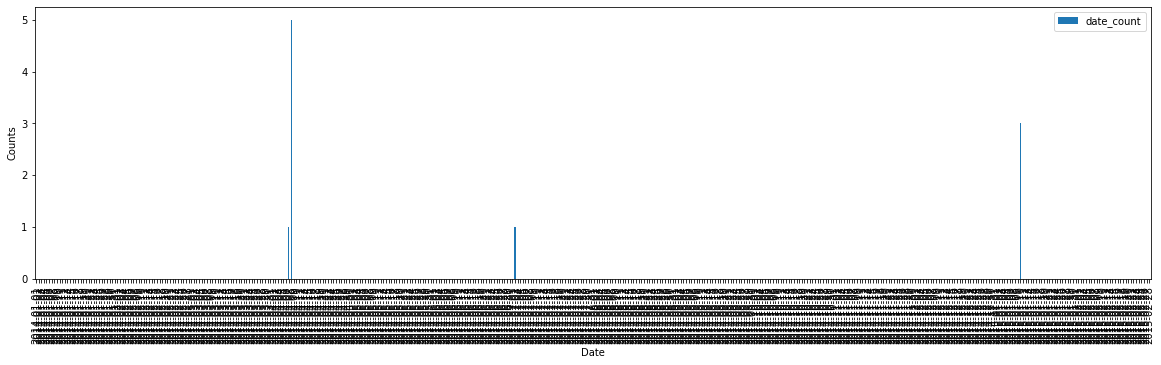

In [37]:
# Put all together: Image Meta data, image classification (face_detector via cv2 and ImageNet), create DataFrame  
os.environ['KMP_DUPLICATE_LIB_OK']='True'
df = pd.DataFrame()
dict = reset_dict()

root = image_folder
file_count = 0 
file_count_backup = 0
round_count = 0
append_mode = False

if os.path.isfile(image_folder +'.xlsx'):
    append_mode = True
    head, tail = os.path.split(image_folder + '.xlsx') 
    df = pd.read_excel(image_folder +'.xlsx') 
    df.drop_duplicates(subset ="img_path", keep = 'first', inplace = True) 
    df.sort_values('date_time', inplace=True, ascending=True)
    df['date'] = df['date_time'].dt.date
    df.reset_index(drop=True, inplace=True)
    df.drop(columns=['Unnamed: 0'], inplace=True)
    dest_path = os.path.join(file_path_copy_dataframe, tail)
    copyfile(image_folder +'.xlsx', dest_path)
    
    img_path_list = df['img_path'].to_list()
    df_counts, missing_days = count_images_per_day(df)
    display(df_counts)
    print('# of missing days: ', len(missing_days))
    
    try:  
        speaker.Speak("Für " + str(len(missing_days)) + " Tage wurden im angegebenen Zeitbereich noch keine Bilder gefunden.")
        #speaker.Speak("On " + str(len(missing_days)) + " days within the timeframe pictures were still not found.")
    except:
        #os.system("say 'On {} days within the timeframe pictures were stil not found.'".format(str(len(missing_days))))
        os.system("say 'Für {} Tage wurden im angegebenen Zeitbereich noch keine Bilder gefunden.'".format(str(len(missing_days))))
    else: 
        print('On ' + str(len(missing_days)) + 'days within the timeframe pictures were stil not found.')
    
    plot_imageCount_per_day()
    
              
else: 
    img_path_list = []
    df = pd.DataFrame.from_dict(dict)
    df.to_excel(image_folder +'.xlsx') 
    
display(df)

<a id='part_a_9'></a>

## Part A 9 - Convert DataFrame to HTML

,img_path,img_path_yolo,image,image_yolo,date_time,GPS,classes_yolo,classes_ImgNet,classes_ImgNet_idx,class_ImgNet_add,date
0,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2337.JPG,NaN,,None,2014-04-07 16:05:00,"(-0.22069, -78.514295)",[],['desk'],526,"[(['desk'], 10.905152320861816), (['oscilloscope', 'scope', 'cathode-ray_oscilloscope', 'CRO'], 8.290132522583008), (['microwave', 'microwave_oven'], 5.430989742279053), (['cash_machine', 'cash_dispenser', 'automated_teller_machine', 'automatic_teller_machine', 'automated_teller', 'automatic_teller', 'ATM'], 4.8843841552734375), (['printer'], 3.856144905090332)]",2014-04-07
1,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2392.JPG,NaN,,None,2014-04-08 09:28:52,"(-0.0019249999999999998, -78.455715)",[],"['traffic_light', 'traffic_signal', 'stoplight']",920,"[(['traffic_light', 'traffic_signal', 'stoplight'], 20.597414016723633), (['pole'], 5.19158935546875), (['punching_bag', 'punch_bag', 'punching_ball', 'punchball'], 4.949164867401123), (['chime', 'bell', 'gong'], 4.743166446685791), (['ping-pong_ball'], 3.569833517074585)]",2014-04-08
2,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2403.JPG,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_yolo/DSCN2403.JPG,,,2014-04-08 09:37:19,"(-0.0021316666666666667, -78.45512666666667)","['person', 'person', 'person', 'person', 'person', 'person']",['sundial'],835,"[(['sundial'], 37.643470764160156), (['street_sign'], 23.943283081054688), (['obelisk'], 13.030181884765625), (['brass', 'memorial_tablet', 'plaque'], 6.633235454559326), (['flagpole', 'flagstaff'], 5.475920677185059)]",2014-04-08
3,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2427.JPG,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_yolo/DSCN2427.JPG,,,2014-04-08 10:14:57,"(-0.0012516666666666668, -78.45421333333334)",['person'],['jigsaw_puzzle'],611,"[(['jigsaw_puzzle'], 62.14563751220703), (['comic_book'], 20.232364654541016), (['tile_roof'], 5.361308574676514), (['book_jacket', 'dust_cover', 'dust_jacket', 'dust_wrapper'], 4.019618511199951), (['fountain'], 1.6617525815963745)]",2014-04-08
4,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2428.JPG,NaN,,None,2014-04-08 10:15:07,"(-0.0013016666666666667, -78.45416166666666)",[],['hamster'],333,"[(['hamster'], 43.60765075683594), (['rotisserie'], 29.749292373657227), (['Angora', 'Angora_rabbit'], 8.012994766235352), (['wood_rabbit', 'cottontail', 'cottontail_rabbit'], 2.398911237716675), (['guinea_pig', 'Cavia_cobaya'], 2.166126251220703)]",2014-04-08
5,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2441.JPG,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images_yolo/DSCN2441.JPG,,,2014-04-08 12:45:57,"(None, None)","['person', 'cup', 'bowl', 'bowl', 'diningtable']",['soup_bowl'],809,"[(['soup_bowl'], 21.564556121826172), (['plate'], 18.82248878479004), (['consomme'], 15.04791259765625), (['burrito'], 4.28341007232666), (['hot_pot', 'hotpot'], 3.4890596866607666)]",2014-04-08
6,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN0915.JPG,NaN,,None,2014-07-02 11:56:22,"(3.5417549999999998, 98.11431499999999)",[],"['orangutan', 'orang', 'orangutang', 'Pongo_pygmaeus']",365,"[(['orangutan', 'orang', 'orangutang', 'Pongo_pygmaeus'], 98.86372375488281), (['spider_monkey', 'Ateles_geoffroyi'], 0.5880008935928345), (['howler_monkey', 'howler'], 0.4104492664337158), (['proboscis_monkey', 'Nasalis_larvatus'], 0.05122902989387512), (['siamang', 'Hylobates_syndactylus', 'Symphalangus_syndactylus'], 0.020050330087542534)]",2014-07-02
7,/Users/davidhartmann/Dropbox/Python/around_the_world_classifier/images/DSCN2273.JPG,NaN,,None,2015-01-10 11:10:19,"(21.689103333333332, 72.97965333333333)",[],['monastery'],663,"[(['monastery'], 20.08843994140625), (['beacon', 'lighthouse', 'beacon_light', 'p
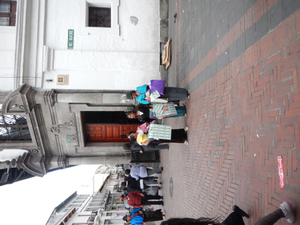
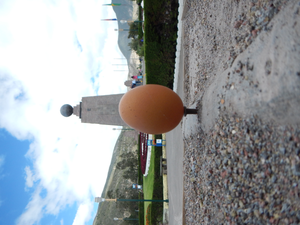
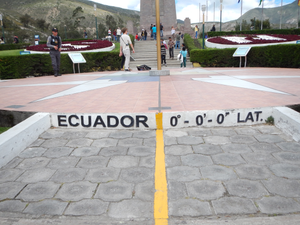
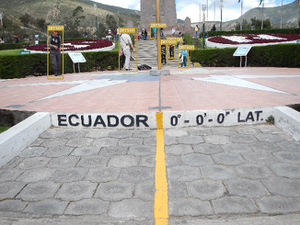
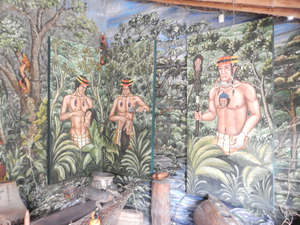
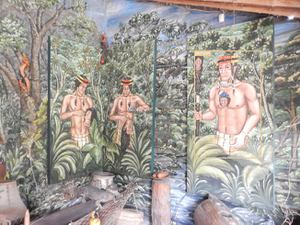
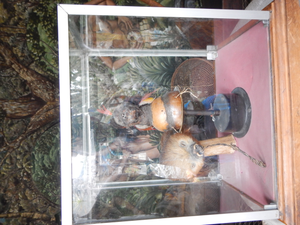
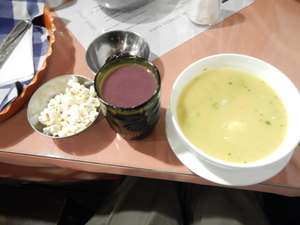
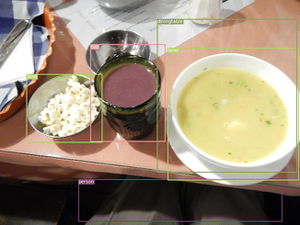
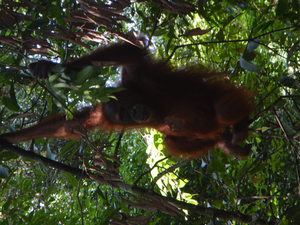
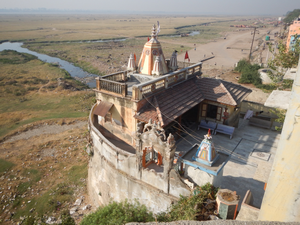
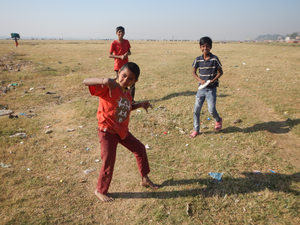
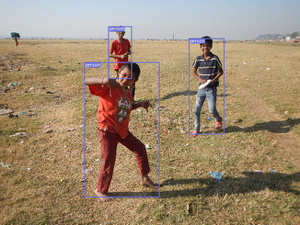
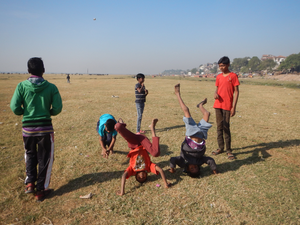
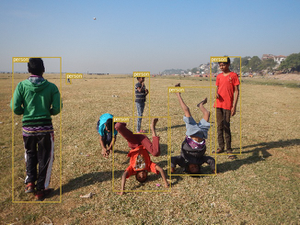

In [38]:
import math

if append_mode == True:
    df['image'] = df.apply(lambda row: get_thumbnail(row['img_path']), axis = 1)
    
    df['exists'] = df.apply(lambda row: check_file_path(row['img_path_yolo']), axis = 1)
    

    #df['img_path_yolo'].fillna(0, inplace=True)
    
    df['image_yolo'] = df.apply(lambda row: get_thumbnail(row['img_path_yolo']) if row['exists'] == True else None, axis = 1)
    
    try: 
        df.drop('exists', inplace =True, axis=1)
    except:
        pass
else:
    print('except')
    pass

# Convert DataFrame to HTML, displaying PIL.Image objects embedded in dataframe
a=HTML(df.to_html(formatters={'image': image_formatter, 'image_yolo': image_formatter}, escape=False))
a


In [39]:
from IPython.core.display import HTML
html = a.data
with open(image_folder + '.html', 'w') as f:
    f.write(html)

<a id='part_a_10'></a>

## Part A 10 - Create GMAPS

In [40]:
wwww
img_path_list = []
for path in df['img_path'].to_list():
    head, tail = os.path.split(path)
    path_segments = path.split('/')
    cwd_segments = cwd.split('/')
    new_pth_segments = [x for x in path_segments if x not in cwd_segments]

    path_string = '/'.join(new_pth_segments)

    img_path_list.append(os.path.join(path_string))



image_data_sets = [{'img_path' : df['img_path'].to_list()[index], 
               'img_path_infobox' : img_path_list[index],
               'date_time' : df['date_time'].to_list()[index], 
               'GPS' : eval(str(df['GPS'].to_list()[index])),
               'classes_yolo' : df['classes_yolo'].to_list()[index],
               'classes_ImgNet' : df['classes_ImgNet'].to_list()[index]
              } for index in range(len(df['img_path'].to_list()))]

image_locations = [image['GPS'] for image in image_data_sets if image['GPS'] != (None,None)]
info_box_template = """
<dl>
<dt>Image Path</dt><dd>{img_path}</dd>
<dt>Date & Time</dt><dd>{date_time}</dd>
<dt>GPS</dt><dd>{GPS}</dd>
<dt>classes_yolo</dt><dd>{classes_yolo}</dd>
<dt>classes_ImgNet</dt><dd>{classes_ImgNet}</dd>
<img src={img_path_infobox} width="300">
</dl>
"""

image_info = [info_box_template.format(**image) for image in image_data_sets if image['GPS'] != (None,None)]



marker_layer = gmaps.marker_layer(image_locations, info_box_content=image_info)
fig = gmaps.figure()
fig.add_layer(marker_layer)


try:
    speaker.Speak("Zu {} Bildern wurden GPS Daten gefunden".format(len(image_locations)))
    #speaker.Speak("For {} images I found GPS data".format(len(image_locations)))
    
except:
    #os.system("say 'For {} images I found GPS data'".format(len(image_locations)))
    os.system("say 'Zu {} Bildern wurden GPS Daten gefunden'".format(len(image_locations)))

else: 
    print('For {} images GPS data was found'.format(len(image_locations)))

fig

NameError: name 'wwww' is not defined

<a id='part_b'></a>

## Part B - Analyze the DataFrame
#### <a href='#part_b_1'>Part B 1 - Time Periods</a>
#### <a href='#part_b_2'>Part B 2 - GPS Areas</a>
#### <a href='#part_b_3'>Part B 3 - Filter by Groups</a>
#### <a href='#part_b_4'>Part B 4 - Personal Filter</a>
#### <a href='#part_b_5'>Part B 5 - Set parameters</a>

<a id='part_b_1'></a>

### Part B 1 - Time Periods
Provide a **start_datetime** and an **end_datetime** in  the format **YYYY-MM-DD HH:MM:SS**

In [ ]:
def time_periods_eval(df_in):
    if time_periods == True:
        datetime_filter_lower = df_in['date_time'] >= start_datetime
        datetime_filter_upper = df_in['date_time'] <= end_datetime

        # Select all cases where df['date_time'] >= start_datetime and df['date_time'] <= end_datetime
        df_filter = df_in[datetime_filter_lower & datetime_filter_upper]
        df_filter.sort_values('date_time', inplace=True, ascending=True)
    else:
        df_filter = df_in
    return df_filter

<a id='part_b_2'></a>

### Part B 2 - GPS Areas

In [ ]:
def gps_areas_eval(df_in):
    if gps_areas == True:
        
        df_in['GPS_la'] = df_in['GPS'].str[0] 
        df_in['GPS_lo'] = df_in['GPS'].str[1]
        
        longitude_filter_w = df_in['GPS_lo']  >= longitude_w
        longitude_filter_e = df_in['GPS_lo']  <= longitude_e
        latitude_filter_s = df_in['GPS_la']  >= latitude_s
        latitude_filter_n = df_in['GPS_la']  <= latitude_n

        df_filter = df_in[longitude_filter_w & longitude_filter_e & latitude_filter_n & latitude_filter_s]
        #df_filter = df[latitude_filter_n & latitude_filter_s]
        df_filter.sort_values('date_time', inplace=True, ascending=True)
        
    else: 
        df_filter = df_in
    return df_filter


<a id='part_b_3'></a>

### Part B 3 - Filter by Groups

In [ ]:
def filter_by_groups_eval(df_in):
    if filter_by_groups == True:
        classes_yolo = [eval(x) for x in df_in['classes_yolo'].to_list()]
        classes_yolo_merged = list(itertools.chain(*classes_yolo))
        df_in['yolo_chosen'] = np.nan
        df_in['yolo_chosen'] = [yolo_filter in j for j in classes_yolo]
       
        classes_ImgNet = [eval(x) for x in df_in['classes_ImgNet'].to_list()]
        classes_ImgNet_merged = list(itertools.chain(*classes_ImgNet))
        df_in['ImgNet_chosen'] = np.nan
        df_in['ImgNet_chosen'] = [imageNet_filter in j for j in classes_ImgNet]
        
        if yolo_filter !='' and imageNet_filter =='':
            if yolo_filter in classes_yolo_merged:
                df_filter = df_in[df_in.yolo_chosen]
            else:
                df_filter = df_in
            
        if yolo_filter =='' and imageNet_filter !='':
            if imageNet_filter in classes_ImgNet_merged:
                df_filter = df_in[df_in.ImgNet_chosen]
            else:
                df_filter = df_in
              
        if yolo_filter !='' and imageNet_filter !='':
            if yolo_filter in classes_yolo_merged and imageNet_filter in classes_ImgNet_merged:
                print('case1')
                df_filter = df_in[df_in.yolo_chosen | df_in.ImgNet_chosen]
            elif yolo_filter not in classes_yolo_merged and imageNet_filter in classes_ImgNet_merged:
                print('case2')
                df_filter = df_in[df_in.ImgNet_chosen]
            elif yolo_filter in classes_yolo_merged and imageNet_filter not in classes_ImgNet_merged:
                print('case3')
                df_filter = df_in[df_in.yolo_chosen]
            else:
                print('case4')
                df_filter = df_in
            
        df_filter.sort_values('date_time', inplace=True, ascending=True)
        
    else: 
        df_filter = df_in
    return df_filter
        

<a id='part_b_4'></a>

### Part B 4 - Personal Filter
Set personal_filter to True/False

In [ ]:
def personal_filter_eval(df):
    if personal_filter == True:
        df_filter = df

    else: 
        df_filter = df
    return df_filter
    

<a id='part_b_5'></a>

### Part B 5 - Set parameters

In this part you can analyze, filter, rearrange or group your images ragarding Time Periods, GPS Areas as well as based on Classification Data. Filtering is done via analyzing the DataFrame df.
You can apply the different filter groups separately or in combination. For this purpose set the following boolean values to True/False.

If you want to save the filter result to file (xlsx and html) then set save_to_file to True.

<img src="data/longitude_latitude_map.png" width="500">

In [ ]:
time_periods = True
start_datetime = '2008-06-04 13:44:56'
end_datetime = '2014-08-03 13:44:56'

gps_areas = False
latitude_n = 20
latitude_s = 15
longitude_w = 90
longitude_e = 130

filter_by_groups = True
yolo_filter = 'person'
imageNet_filter = 'curly-coated retriever'

personal_filter = False

save_to_file = False

df_filter = time_periods_eval(df)
df_filter = gps_areas_eval(df_filter)
df_filter = filter_by_groups_eval(df_filter)

df_filter

In [ ]:
df_filter['image'] = df_filter.apply(lambda row: get_thumbnail(row['img_path']), axis = 1)
df_filter['img_path_yolo'].fillna(0, inplace=True)
df_filter['image_yolo'] = df_filter.apply(lambda row: get_thumbnail(row['img_path_yolo']) if row['img_path_yolo'] != 0 else None, axis = 1)
# Convert DataFrame to HTML, displaying PIL.Image objects embedded in dataframe
a=HTML(df_filter.to_html(formatters={'image': image_formatter, 'image_yolo': image_formatter}, escape=False))
a

<a id='Appendix'></a>

### Appendix - Yolo and ImageNet classes

##### yolo classes:

- person
- bicycle, car, motorbike, aeroplane, bus, train, truck, boat
- traffic light, fire hydrant, stop sign, parking meter, bench
- cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe
- backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket
- bottle, wine glass, cup, fork, knife, spoon, bowl
- banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake
- chair, sofa, pottedplant, bed, diningtable, toilet, tvmonitor, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush

##### ImageNet classes:
- tench, Tinca tinca
- goldfish, Carassius auratus
- great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
- tiger shark, Galeocerdo cuvieri
- hammerhead, hammerhead shark
- electric ray, crampfish, numbfish, torpedo
- stingray
- cock
- hen
- ostrich, Struthio camelus
- brambling, Fringilla montifringilla
- goldfinch, Carduelis carduelis
- house finch, linnet, Carpodacus mexicanus
- junco, snowbird
- indigo bunting, indigo finch, indigo bird, Passerina cyanea
- robin, American robin, Turdus migratorius
- bulbul
- jay
- magpie
- chickadee
- water ouzel, dipper
- kite
- bald eagle, American eagle, Haliaeetus leucocephalus
- vulture
- great grey owl, great gray owl, Strix nebulosa
- European fire salamander, Salamandra salamandra
- common newt, Triturus vulgaris
- eft
- spotted salamander, Ambystoma maculatum
- axolotl, mud puppy, Ambystoma mexicanuma
- bullfrog, Rana catesbeiana
- tree frog, tree-frog
- tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
- loggerhead, loggerhead turtle, Caretta caretta
- leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea
- mud turtle
- terrapin
- box turtle, box tortoise
- banded gecko
- common iguana, iguana, Iguana iguana
- American chameleon, anole, Anolis carolinensis
- whiptail, whiptail lizard
- agama
- frilled lizard, Chlamydosaurus kingi
- alligator lizard
- Gila monster, Heloderma suspectum
- green lizard, Lacerta viridis
- African chameleon, Chamaeleo chamaeleon
- Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis
- African crocodile, Nile crocodile, Crocodylus niloticus
- American alligator, Alligator mississipiensis
- triceratops
- thunder snake, worm snake, Carphophis amoenus
- ringneck snake, ring-necked snake, ring snake
- hognose snake, puff adder, sand viper
- green snake, grass snake
- king snake, kingsnake
- garter snake, grass snake
- water snake
- vine snake
- night snake, Hypsiglena torquata
- boa constrictor, Constrictor constrictor
- rock python, rock snake, Python sebae
- Indian cobra, Naja naja
- green mamba
- sea snake
- horned viper, cerastes, sand viper, horned asp, Cerastes cornutus
- diamondback, diamondback rattlesnake, Crotalus adamanteus
- sidewinder, horned rattlesnake, Crotalus cerastes
- trilobite
- harvestman, daddy longlegs, Phalangium opilio
- scorpion
- black and gold garden spider, Argiope aurantia
- barn spider, Araneus cavaticus
- garden spider, Aranea diademata
- black widow, Latrodectus mactans
- tarantula
- wolf spider, hunting spider
- tick
- centipede
- black grouse
- ptarmigan
- ruffed grouse, partridge, Bonasa umbellus
- prairie chicken, prairie grouse, prairie fowl
- peacock
- quail
- partridge
- African grey, African gray, Psittacus erithacus
- macaw
- sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita
- lorikeet
- coucal
- bee eater
- hornbill
- hummingbird
- jacamar
- toucan
- drake
- red-breasted merganser, Mergus serrator
- goose
- black swan, Cygnus atratus
- tusker
- echidna, spiny anteater, anteater
- platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
- wallaby, brush kangaroo
- koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
- wombat
- jellyfish
- sea anemone, anemone
- brain coral
- flatworm, platyhelminth
- nematode, nematode worm, roundworm
- conch
- snail
- slug
- sea slug, nudibranch
- chiton, coat-of-mail shell, sea cradle, polyplacophore
- chambered nautilus, pearly nautilus, nautilus
- Dungeness crab, Cancer magister
- rock crab, Cancer irroratus
- fiddler crab
- king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica
- American lobster, Northern lobster, Maine lobster, Homarus americanus
- spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
- crayfish, crawfish, crawdad, crawdaddy
- hermit crab
- isopod
- white stork, Ciconia ciconia
- black stork, Ciconia nigra
- spoonbill
- flamingo
- little blue heron, Egretta caerulea
- American egret, great white heron, Egretta albus
- bittern
- crane
- limpkin, Aramus pictus
- European gallinule, Porphyrio porphyrio
- American coot, marsh hen, mud hen, water hen, Fulica americana
- bustard
- ruddy turnstone, Arenaria interpres
- red-backed sandpiper, dunlin, Erolia alpina
- redshank, Tringa totanus
- dowitcher
- oystercatcher, oyster catcher
- pelican
- king penguin, Aptenodytes patagonica
- albatross, mollymawk
- grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus
- killer whale, killer, orca, grampus, sea wolf, Orcinus orca
- dugong, Dugong dugon
- sea lion
- Chihuahua
- Japanese spaniel
- Maltese dog, Maltese terrier, Maltese
- Pekinese, Pekingese, Peke
- Shih-Tzu
- Blenheim spaniel
- papillon
- toy terrier
- Rhodesian ridgeback
- Afghan hound, Afghan
- basset, basset hound
- beagle
- bloodhound, sleuthhound
- bluetick
- black-and-tan coonhound
- Walker hound, Walker foxhound
- English foxhound
- redbone
- borzoi, Russian wolfhound
- Irish wolfhound
- Italian greyhound
- whippet
- Ibizan hound, Ibizan Podenco
- Norwegian elkhound, elkhound
- otterhound, otter hound
- Saluki, gazelle hound
- Scottish deerhound, deerhound
- Weimaraner
- Staffordshire bullterrier, Staffordshire bull terrier
- American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier
- Bedlington terrier
- Border terrier
- Kerry blue terrier
- Irish terrier
- Norfolk terrier
- Norwich terrier
- Yorkshire terrier
- wire-haired fox terrier
- Lakeland terrier
- Sealyham terrier, Sealyham
- Airedale, Airedale terrier
- cairn, cairn terrier
- Australian terrier
- Dandie Dinmont, Dandie Dinmont terrier
- Boston bull, Boston terrier
- miniature schnauzer
- giant schnauzer
- standard schnauzer
- Scotch terrier, Scottish terrier, Scottie
- Tibetan terrier, chrysanthemum dog
- silky terrier, Sydney silky
- soft-coated wheaten terrier
- West Highland white terrier
- Lhasa, Lhasa apso
- flat-coated retriever
- curly-coated retriever
- golden retriever
- Labrador retriever
- Chesapeake Bay retriever
- German short-haired pointer
- vizsla, Hungarian pointer
- English setter
- Irish setter, red setter
- Gordon setter
- Brittany spaniel
- clumber, clumber spaniel
- English springer, English springer spaniel
- Welsh springer spaniel
- cocker spaniel, English cocker spaniel, cocker
- Sussex spaniel
- Irish water spaniel
- kuvasz
- schipperke
- groenendael
- malinois
- briard
- kelpie
- komondor
- Old English sheepdog, bobtail
- Shetland sheepdog, Shetland sheep dog, Shetland
- collie
- Border collie
- Bouvier des Flandres, Bouviers des Flandres
- Rottweiler
- German shepherd, German shepherd dog, German police dog, alsatian
- Doberman, Doberman pinscher
- miniature pinscher
- Greater Swiss Mountain dog
- Bernese mountain dog
- Appenzeller
- EntleBucher
- boxer
- bull mastiff
- Tibetan mastiff
- French bulldog
- Great Dane
- Saint Bernard, St Bernard
- Eskimo dog, husky
- malamute, malemute, Alaskan malamute
- Siberian husky
- dalmatian, coach dog, carriage dog
- affenpinscher, monkey pinscher, monkey dog
- basenji
- pug, pug-dog
- Leonberg
- Newfoundland, Newfoundland dog
- Great Pyrenees
- Samoyed, Samoyede
- Pomeranian
- chow, chow chow
- keeshond
- Brabancon griffon
- Pembroke, Pembroke Welsh corgi
- Cardigan, Cardigan Welsh corgi
- toy poodle
- miniature poodle
- standard poodle
- Mexican hairless
- timber wolf, grey wolf, gray wolf, Canis lupus
- white wolf, Arctic wolf, Canis lupus tundrarum
- red wolf, maned wolf, Canis rufus, Canis niger
- coyote, prairie wolf, brush wolf, Canis latrans
- dingo, warrigal, warragal, Canis dingo
- dhole, Cuon alpinus
- African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus
- hyena, hyaena
- red fox, Vulpes vulpes
- kit fox, Vulpes macrotis
- Arctic fox, white fox, Alopex lagopus
- grey fox, gray fox, Urocyon cinereoargenteus
- tabby, tabby cat
- tiger cat
- Persian cat
- Siamese cat, Siamese
- Egyptian cat
- cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
- lynx, catamount
- leopard, Panthera pardus
- snow leopard, ounce, Panthera uncia
- jaguar, panther, Panthera onca, Felis onca
- lion, king of beasts, Panthera leo
- tiger, Panthera tigris
- cheetah, chetah, Acinonyx jubatus
- brown bear, bruin, Ursus arctos
- American black bear, black bear, Ursus americanus, Euarctos americanus
- ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus
- sloth bear, Melursus ursinus, Ursus ursinus
- mongoose
- meerkat, mierkat
- tiger beetle
- ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle
- ground beetle, carabid beetle
- long-horned beetle, longicorn, longicorn beetle
- leaf beetle, chrysomelid
- dung beetle
- rhinoceros beetle
- weevil
- fly
- bee
- ant, emmet, pismire
- grasshopper, hopper
- cricket
- walking stick, walkingstick, stick insect
- cockroach, roach
- mantis, mantid
- cicada, cicala
- leafhopper
- lacewing, lacewing fly
- dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk,
- damselfly
- admiral
- ringlet, ringlet butterfly
- monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
- cabbage butterfly
- sulphur butterfly, sulfur butterfly
- lycaenid, lycaenid butterfly
- starfish, sea star
- sea urchin
- sea cucumber, holothurian
- wood rabbit, cottontail, cottontail rabbit
- hare
- Angora, Angora rabbit
- hamster
- porcupine, hedgehog
- fox squirrel, eastern fox squirrel, Sciurus niger
- marmot
- beaver
- guinea pig, Cavia cobaya
- sorrel
- zebra
- hog, pig, grunter, squealer, Sus scrofa
- wild boar, boar, Sus scrofa
- warthog
- hippopotamus, hippo, river horse, Hippopotamus amphibius
- ox
- water buffalo, water ox, Asiatic buffalo, Bubalus bubalis
- bison
- ram, tup
- bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis
- ibex, Capra ibex
- hartebeest
- impala, Aepyceros melampus
- gazelle
- Arabian camel, dromedary, Camelus dromedarius
- llama
- weasel
- mink
- polecat, fitch, foulmart, foumart, Mustela putorius
- black-footed ferret, ferret, Mustela nigripes
- otter
- skunk, polecat, wood pussy
- badger
- armadillo
- three-toed sloth, ai, Bradypus tridactylus
- orangutan, orang, orangutang, Pongo pygmaeus
- gorilla, Gorilla gorilla
- chimpanzee, chimp, Pan troglodytes
- gibbon, Hylobates lar
- siamang, Hylobates syndactylus, Symphalangus syndactylus
- guenon, guenon monkey
- patas, hussar monkey, Erythrocebus patas
- baboon
- macaque
- langur
- colobus, colobus monkey
- proboscis monkey, Nasalis larvatus
- marmoset
- capuchin, ringtail, Cebus capucinus
- howler monkey, howler
- titi, titi monkey
- spider monkey, Ateles geoffroyi
- squirrel monkey, Saimiri sciureus
- Madagascar cat, ring-tailed lemur, Lemur catta
- indri, indris, Indri indri, Indri brevicaudatus
- Indian elephant, Elephas maximus
- African elephant, Loxodonta africana
- lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
- giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
- barracouta, snoek
- eel
- coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch
- rock beauty, Holocanthus tricolor
- anemone fish
- sturgeon
- gar, garfish, garpike, billfish, Lepisosteus osseus
- lionfish
- puffer, pufferfish, blowfish, globefish
- abacus
- abaya
- academic gown, academic robe, judge's robe,
- accordion, piano accordion, squeeze box
- acoustic guitar
- aircraft carrier, carrier, flattop, attack aircraft carrier
- airliner
- airship, dirigible
- altar
- ambulance
- amphibian, amphibious vehicle
- analog clock
- apiary, bee house
- apron
- ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin
- assault rifle, assault gun
- backpack, back pack, knapsack, packsack, rucksack, haversack
- bakery, bakeshop, bakehouse
- balance beam, beam
- balloon
- ballpoint, ballpoint pen, ballpen, Biro
- Band Aid
- banjo
- bannister, banister, balustrade, balusters, handrail
- barbell
- barber chair
- barbershop
- barn
- barometer
- barrel, cask
- barrow, garden cart, lawn cart, wheelbarrow
- baseball
- basketball
- bassinet
- bassoon
- bathing cap, swimming cap
- bath towel
- bathtub, bathing tub, bath, tub
- beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
- beacon, lighthouse, beacon light, pharos
- beaker
- bearskin, busby, shako
- beer bottle
- beer glass
- bell cote, bell cot
- bib
- bicycle-built-for-two, tandem bicycle, tandem
- bikini, two-piece
- binder, ring-binder
- binoculars, field glasses, opera glasses
- birdhouse
- boathouse
- bobsled, bobsleigh, bob
- bolo tie, bolo, bola tie, bola
- bonnet, poke bonnet
- bookcase
- bookshop, bookstore, bookstall
- bottlecap
- bow
- bow tie, bow-tie, bowtie
- brass, memorial tablet, plaque
- brassiere, bra, bandeau
- breakwater, groin, groyne, mole, bulwark, seawall, jetty
- breastplate, aegis, egis
- broom
- bucket, pail
- buckle
- bulletproof vest
- bullet train, bullet
- butcher shop, meat market
- cab, hack, taxi, taxicab
- caldron, cauldron
- candle, taper, wax light
- cannon
- canoe
- can opener, tin opener
- cardigan
- car mirror
- carousel, carrousel, merry-go-round, roundabout, whirligig
- carpenter's kit, tool kit,
- carton
- car wheel
- cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM
- cassette
- cassette player
- castle
- catamaran
- CD player
- cello, violoncello
- cellular telephone, cellular phone, cellphone, cell, mobile phone
- chain
- chainlink fence
- chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour
- chain saw, chainsaw
- chest
- chiffonier, commode
- chime, bell, gong
- china cabinet, china closet
- Christmas stocking
- church, church building
- cinema, movie theater, movie theatre, movie house, picture palace
- cleaver, meat cleaver, chopper
- cliff dwelling
- cloak
- clog, geta, patten, sabot
- cocktail shaker
- coffee mug
- coffeepot
- coil, spiral, volute, whorl, helix
- combination lock
- computer keyboard, keypad
- confectionery, confectionary, candy store
- container ship, containership, container vessel
- convertible
- corkscrew, bottle screw
- cornet, horn, trumpet, trump
- cowboy boot
- cowboy hat, ten-gallon hat
- cradle
- crane
- crash helmet
- crate
- crib, cot
- Crock Pot
- croquet ball
- crutch
- cuirass
- dam, dike, dyke
- desk
- desktop computer
- dial telephone, dial phone
- diaper, nappy, napkin
- digital clock
- digital watch
- dining table, board
- dishrag, dishcloth
- dishwasher, dish washer, dishwashing machine
- disk brake, disc brake
- dock, dockage, docking facility
- dogsled, dog sled, dog sleigh
- dome
- doormat, welcome mat
- drilling platform, offshore rig
- drum, membranophone, tympan
- drumstick
- dumbbell
- Dutch oven
- electric fan, blower
- electric guitar
- electric locomotive
- entertainment center
- envelope
- espresso maker
- face powder
- feather boa, boa
- file, file cabinet, filing cabinet
- fireboat
- fire engine, fire truck
- fire screen, fireguard
- flagpole, flagstaff
- flute, transverse flute
- folding chair
- football helmet
- forklift
- fountain
- fountain pen
- four-poster
- freight car
- French horn, horn
- frying pan, frypan, skillet
- fur coat
- garbage truck, dustcart
- gasmask, respirator, gas helmet
- gas pump, gasoline pump, petrol pump, island dispenser
- goblet
- go-kart
- golf ball
- golfcart, golf cart
- gondola
- gong, tam-tam
- gown
- grand piano, grand
- greenhouse, nursery, glasshouse
- grille, radiator grille
- grocery store, grocery, food market, market
- guillotine
- hair slide
- hair spray
- half track
- hammer
- hamper
- hand blower, blow dryer, blow drier, hair dryer, hair drier
- hand-held computer, hand-held microcomputer
- handkerchief, hankie, hanky, hankey
- hard disc, hard disk, fixed disk
- harmonica, mouth organ, harp, mouth harp
- harp
- harvester, reaper
- hatchet
- holster
- home theater, home theatre
- honeycomb
- hook, claw
- hoopskirt, crinoline
- horizontal bar, high bar
- horse cart, horse-cart
- hourglass
- iPod
- iron, smoothing iron
- jack-o'-lantern,
- jean, blue jean, denim
- jeep, landrover
- jersey, T-shirt, tee shirt
- jigsaw puzzle
- jinrikisha, ricksha, rickshaw
- joystick
- kimono
- knee pad
- knot
- lab coat, laboratory coat
- ladle
- lampshade, lamp shade
- laptop, laptop computer
- lawn mower, mower
- lens cap, lens cover
- letter opener, paper knife, paperknife
- library
- lifeboat
- lighter, light, igniter, ignitor
- limousine, limo
- liner, ocean liner
- lipstick, lip rouge
- Loafer
- lotion
- loudspeaker, speaker, speaker unit, loudspeaker system, speaker system
- loupe, jeweler's loupe,
- lumbermill, sawmill
- magnetic compass
- mailbag, postbag
- mailbox, letter box
- maillot
- maillot, tank suit
- manhole cover
- maraca
- marimba, xylophone
- mask
- matchstick
- maypole
- maze, labyrinth
- measuring cup
- medicine chest, medicine cabinet
- megalith, megalithic structure
- microphone, mike
- microwave, microwave oven
- military uniform
- milk can
- minibus
- miniskirt, mini
- minivan
- missile
- mitten
- mixing bowl
- mobile home, manufactured home
- Model T
- modem
- monastery
- monitor
- moped
- mortar
- mortarboard
- mosque
- mosquito net
- motor scooter, scooter
- mountain bike, all-terrain bike, off-roader
- mountain tent
- mouse, computer mouse
- mousetrap
- moving van
- muzzle
- nail
- neck brace
- necklace
- nipple
- notebook, notebook computer
- obelisk
- oboe, hautboy, hautbois
- ocarina, sweet potato
- odometer, hodometer, mileometer, milometer
- oil filter
- organ, pipe organ
- oscilloscope, scope, cathode-ray oscilloscope, CRO
- overskirt
- oxcart
- oxygen mask
- packet
- paddle, boat paddle
- paddlewheel, paddle wheel
- padlock
- paintbrush
- pajama, pyjama, pj's, jammies,
- palace
- panpipe, pandean pipe, syrinx
- paper towel
- parachute, chute
- parallel bars, bars
- park bench
- parking meter
- passenger car, coach, carriage
- patio, terrace
- pay-phone, pay-station
- pedestal, plinth, footstall
- pencil box, pencil case
- pencil sharpener
- perfume, essence
- Petri dish
- photocopier
- pick, plectrum, plectron
- pickelhaube
- picket fence, paling
- pickup, pickup truck
- pier
- piggy bank, penny bank
- pill bottle
- pillow
- ping-pong ball
- pinwheel
- pirate, pirate ship
- pitcher, ewer
- plane, carpenter's plane, woodworking plane,
- planetarium
- plastic bag
- plate rack
- plow, plough
- plunger, plumber's helper,
- Polaroid camera, Polaroid Land camera
- pole
- police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria
- poncho
- pool table, billiard table, snooker table
- pop bottle, soda bottle
- pot, flowerpot
- potter's wheel,
- power drill
- prayer rug, prayer mat
- printer
- prison, prison house
- projectile, missile
- projector
- puck, hockey puck
- punching bag, punch bag, punching ball, punchball
- purse
- quill, quill pen
- quilt, comforter, comfort, puff
- racer, race car, racing car
- racket, racquet
- radiator
- radio, wireless
- radio telescope, radio reflector
- rain barrel
- recreational vehicle, RV, R.V.
- reel
- reflex camera
- refrigerator, icebox
- remote control, remote
- restaurant, eating house, eating place, eatery
- revolver, six-gun, six-shooter
- rifle
- rocking chair, rocker
- rotisserie
- rubber eraser, rubber, pencil eraser
- rugby ball
- rule, ruler
- running shoe
- safe
- safety pin
- saltshaker, salt shaker
- sandal
- sarong
- sax, saxophone
- scabbard
- scale, weighing machine
- school bus
- schooner
- scoreboard
- screen, CRT screen
- screw
- screwdriver
- seat belt, seatbelt
- sewing machine
- shield, buckler
- shoe shop, shoe-shop, shoe store
- shoji
- shopping basket
- shopping cart
- shovel
- shower cap
- shower curtain
- ski
- ski mask
- sleeping bag
- slide rule, slipstick
- sliding door
- slot, one-armed bandit
- snorkel
- snowmobile
- snowplow, snowplough
- soap dispenser
- soccer ball
- sock
- solar dish, solar collector, solar furnace
- sombrero
- soup bowl
- space bar
- space heater
- space shuttle
- spatula
- speedboat
- spider web, spider's web,
- spindle
- sports car, sport car
- spotlight, spot
- stage
- steam locomotive
- steel arch bridge
- steel drum
- stethoscope
- stole
- stone wall
- stopwatch, stop watch
- stove
- strainer
- streetcar, tram, tramcar, trolley, trolley car
- stretcher
- studio couch, day bed
- stupa, tope
- submarine, pigboat, sub, U-boat
- suit, suit of clothes
- sundial
- sunglass
- sunglasses, dark glasses, shades
- sunscreen, sunblock, sun blocker
- suspension bridge
- swab, swob, mop
- sweatshirt
- swimming trunks, bathing trunks
- swing
- switch, electric switch, electrical switch
- syringe
- table lamp
- tank, army tank, armored combat vehicle, armoured combat vehicle
- tape player
- teapot
- teddy, teddy bear
- television, television system
- tennis ball
- thatch, thatched roof
- theater curtain, theatre curtain
- thimble
- thresher, thrasher, threshing machine
- throne
- tile roof
- toaster
- tobacco shop, tobacconist shop, tobacconist
- toilet seat
- torch
- totem pole
- tow truck, tow car, wrecker
- toyshop
- tractor
- trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi
- tray
- trench coat
- tricycle, trike, velocipede
- trimaran
- tripod
- triumphal arch
- trolleybus, trolley coach, trackless trolley
- trombone
- tub, vat
- turnstile
- typewriter keyboard
- umbrella
- unicycle, monocycle
- upright, upright piano
- vacuum, vacuum cleaner
- vase
- vault
- velvet
- vending machine
- vestment
- viaduct
- violin, fiddle
- volleyball
- waffle iron
- wall clock
- wallet, billfold, notecase, pocketbook
- wardrobe, closet, press
- warplane, military plane
- washbasin, handbasin, washbowl, lavabo, wash-hand basin
- washer, automatic washer, washing machine
- water bottle
- water jug
- water tower
- whiskey jug
- whistle
- wig
- window screen
- window shade
- Windsor tie
- wine bottle
- wing
- wok
- wooden spoon
- wool, woolen, woollen
- worm fence, snake fence, snake-rail fence, Virginia fence
- wreck
- yawl
- yurt
- web site, website, internet site, site
- comic book
- crossword puzzle, crossword
- street sign
- traffic light, traffic signal, stoplight
- book jacket, dust cover, dust jacket, dust wrapper
- menu
- plate
- guacamole
- consomme
- hot pot, hotpot
- trifle
- ice cream, icecream
- ice lolly, lolly, lollipop, popsicle
- French loaf
- bagel, beigel
- pretzel
- cheeseburger
- hotdog, hot dog, red hot
- mashed potato
- head cabbage
- broccoli
- cauliflower
- zucchini, courgette
- spaghetti squash
- acorn squash
- butternut squash
- cucumber, cuke
- artichoke, globe artichoke
- bell pepper
- cardoon
- mushroom
- Granny Smith
- strawberry
- orange
- lemon
- fig
- pineapple, ananas
- banana
- jackfruit, jak, jack
- custard apple
- pomegranate
- hay
- carbonara
- chocolate sauce, chocolate syrup
- dough
- meat loaf, meatloaf
- pizza, pizza pie
- potpie
- burrito
- red wine
- espresso
- cup
- eggnog
- alp
- bubble
- cliff, drop, drop-off
- coral reef
- geyser
- lakeside, lakeshore
- promontory, headland, head, foreland
- sandbar, sand bar
- seashore, coast, seacoast, sea-coast
- valley, vale
- volcano
- ballplayer, baseball player
- groom, bridegroom
- scuba diver
- rapeseed
- daisy
- yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum,
- corn
- acorn
- hip, rose hip, rosehip
- buckeye, horse chestnut, conker
- coral fungus
- agaric
- gyromitra
- stinkhorn, carrion fungus
- earthstar
- hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa
- bolete
- ear, spike, capitulum
- toilet tissue, toilet paper, bathroom tissue